# A simple 2D Flow Matching model

This notebook trains and evaluates a simple 2D FM model with CondOT (i.e., linear) scheduler.

Dataset: 2D checkerboard
Model (velocity): MLP

## Imports and init device

In [ ]:
import time
import torch
import numpy as np
from torch import nn, Tensor

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm

from peft import LoraConfig, get_peft_model
from sklearn.datasets import make_moons
import sys
sys.path.append("/home/u5649209/workspace/flow_matching")  # Adjust the path as necessary to import flow_matching_utils
from flow_matching_utils import MLP, evaluate_result

# To avoide meshgrid warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torch')
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.manual_seed(42)
import numpy as np
from flow_matching_utils import train_moon_gen
from flow_matching_utils import reinit_lora

## Train Velocity Flow Matching model

In [5]:
import os

# training arguments
lr = 0.001
batch_size = 4096
iterations = 3000
print_every = 50
hidden_dim = 512
gradient_base = 0
gradient_iter = 15000
pretrain_iter = 20000
is_pre_train = False
is_lora = True
is_eval = False 
is_reinit = True
gamma = 144
mode = "new"
loss_history = []
lora_init_mode_list = [\
    "lora-ga", \
    "lora-one", \
    "lora-sb"\
]


def train_process():
    start_time = time.time()
    for i in range(iterations):
        optim.zero_grad() 
        def save_model(step_name = None):
            if step_name is None:
                step_name = i + 1
            if not is_pre_train:
                if is_lora:
                    if is_reinit:
                        save_path = f"/home/u5649209/workspace/flow_matching/ckpts/{lora_init_mode}_pretrainiter_{pretrain_iter}_{gradient_base}_{gradient_iter}_gamma{gamma}/{step_name}_{mode}"
                        os.makedirs(save_path, exist_ok=True)
                        vf.save_pretrained(save_path)
                    else:
                        save_path = f"/home/u5649209/workspace/flow_matching/ckpts/lora_{pretrain_iter}/{step_name}_{mode}"
                        os.makedirs(save_path, exist_ok=True)
                        vf.save_pretrained(save_path)
                else:
                    save_path = f"/home/u5649209/workspace/flow_matching/ckpts/fft_{pretrain_iter}/{step_name}_{mode}.pth"
                    if not os.path.exists(os.path.dirname(save_path)):
                        os.makedirs(os.path.dirname(save_path), exist_ok=True)
                    torch.save(vf.state_dict(), save_path)
            else:
                save_path = f"/home/u5649209/workspace/flow_matching/ckpts/weights/{step_name}.pth"
                if not os.path.exists(os.path.dirname(save_path)):
                    os.makedirs(os.path.dirname(save_path), exist_ok=True)
                torch.save(vf.state_dict(), save_path)
        # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1) = N(X_0|0,I)q(X_1)
        x_1, y = train_moon_gen(batch_size=batch_size, device=device, is_pretrain=is_pre_train, mode = mode) # sample data
        # print(y)
        x_1 = torch.tensor(x_1).float().to(device)
        x_0 = torch.randn_like(x_1).to(device)


        # sample time (user's responsibility)
        t = torch.rand(x_1.shape[0]).to(device)
        

        # sample probability path
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)

        # flow matching l2 loss
        loss = torch.pow(vf(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean() 
        loss_history.append(loss.item())
        if i == 0:
            elapsed = time.time() - start_time
            print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} ' 
                .format(i+1, elapsed*1000/print_every, loss.item())) 
            start_time = time.time()
            save_model(step_name=0)
        # optimizer step
        loss.backward() # backward
        optim.step() # update

        
        
        # log loss
        if ((i+1) % print_every == 0) or (i in [0, 1, 2, 3]):
            elapsed = time.time() - start_time
            print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} ' 
                .format(i, elapsed*1000/print_every, loss.item())) 
            start_time = time.time()
            save_model()


if not is_eval:
    vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device) 
    state_dict = torch.load(f"/home/u5649209/workspace/flow_matching/ckpts/weights/raw_model_{pretrain_iter-1}.pth", map_location=device)
    vf.load_state_dict(state_dict)
    if is_lora == False:
        optim = torch.optim.Adam(vf.parameters(), lr=lr)
        # train
        start_time = time.time()
        path = AffineProbPath(scheduler=CondOTScheduler())
        train_process()
    elif is_reinit == False:
        lora_config = LoraConfig(
            r=2,
            lora_alpha=4,
            target_modules=["main.0", "main.2", "main.4", "main.6"],  # target Linear layers in MLP
            )
        vf = get_peft_model(vf, lora_config)
        optim = torch.optim.Adam(vf.parameters(), lr=lr)
        optim.param_groups[0]['params'] = [p for n, p in vf.named_parameters() if 'lora_' in n]
        # train
        start_time = time.time()
        path = AffineProbPath(scheduler=CondOTScheduler())
        train_process()
    else:
        for lora_init_mode in lora_init_mode_list:
            vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device) 
            state_dict = torch.load(f"/home/u5649209/workspace/flow_matching/ckpts/weights/raw_model_{pretrain_iter-1}.pth", map_location=device)
            vf.load_state_dict(state_dict)
            print(f"mode: {mode}, lora_init_mode: {lora_init_mode}, gradient_base: {gradient_base}, gradient_iter: {gradient_iter}, gamma: {gamma}\
                pretrain_iter: {pretrain_iter}")
            
            # reinit the model
            import pickle

            lora_config = LoraConfig(
                r=2,
                lora_alpha=4,
                target_modules=["main.0", "main.2", "main.4", "main.6"],  # target Linear layers in MLP
                init_lora_weights="gaussian",
            )
            vf = get_peft_model(vf, lora_config)
            
            # with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/models_grads_step19999_new.pkl', 'rb') as f:
            with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/fullP{pretrain_iter}_step{gradient_base}_data_new_iter_{gradient_iter}.pkl', 'rb') as f:  # IGNORE
                named_grad = pickle.load(f)
            _ = reinit_lora(vf, gamma, named_grad, init_mode = lora_init_mode, lora_config = lora_config)
            for param in vf.parameters():
                param.data = param.data.contiguous()
    
            optim = torch.optim.Adam(vf.parameters(), lr=lr)
            optim.param_groups[0]['params'] = [p for n, p in vf.named_parameters() if 'lora_' in n]

                


            # train
            start_time = time.time()
            path = AffineProbPath(scheduler=CondOTScheduler())
            train_process()


mode: new, lora_init_mode: lora-ga, gradient_base: 0, gradient_iter: 15000, gamma: 144                pretrain_iter: 20000


Reinitializing Lora: 100%|██████████| 53/53 [00:00<00:00, 545.05it/s]


| iter      1 |  3.89 ms/step | loss    4.471 
| iter      0 |  2.60 ms/step | loss    4.471 
| iter      1 |  0.26 ms/step | loss    4.338 
| iter      2 |  0.18 ms/step | loss    3.698 
| iter      3 |  0.17 ms/step | loss    3.370 
| iter     49 |  7.20 ms/step | loss    1.185 
| iter     99 |  8.54 ms/step | loss    1.028 
| iter    149 |  8.96 ms/step | loss    0.987 
| iter    199 |  8.57 ms/step | loss    0.982 
| iter    249 |  8.64 ms/step | loss    0.978 
| iter    299 |  8.97 ms/step | loss    0.963 
| iter    349 |  8.45 ms/step | loss    0.932 
| iter    399 |  8.49 ms/step | loss    0.935 
| iter    449 |  8.56 ms/step | loss    0.932 
| iter    499 |  8.61 ms/step | loss    0.903 
| iter    549 |  8.43 ms/step | loss    0.928 
| iter    599 |  8.79 ms/step | loss    0.923 
| iter    649 |  8.49 ms/step | loss    0.911 
| iter    699 |  8.61 ms/step | loss    0.871 
| iter    749 |  8.80 ms/step | loss    0.876 
| iter    799 |  8.64 ms/step | loss    0.891 
| iter    849

KeyboardInterrupt: 

In [6]:
if not is_eval:
    plt.figure(figsize=(8, 4))
    plt.plot(loss_history[:])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.grid(True)
    plt.show()

In [7]:

import pickle
from peft import LoraConfig, get_peft_model, PeftModel
# step_list = [2]
step_list = [0, 1 , 2, 3, 4, 50, 100,150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]
lora_ga_nll_list = []
lora_one_nll_list = []
lora_sb_nll_list = []
lora_emd_list = []
fft_list = []
for step in step_list:
    path_list = [
        f"/home/u5649209/workspace/flow_matching/ckpts/lora-sb_pretrainiter_{pretrain_iter}_{gradient_base}_{gradient_iter}_gamma{gamma}/{step}_new",
        f"/home/u5649209/workspace/flow_matching/ckpts/lora-ga_pretrainiter_{pretrain_iter}_{gradient_base}_{gradient_iter}_gamma{gamma}/{step}_new",
        f"/home/u5649209/workspace/flow_matching/ckpts/lora-one_pretrainiter_{pretrain_iter}_{gradient_base}_{gradient_iter}_gamma{gamma}/{step}_new",
        f"/home/u5649209/workspace/flow_matching/ckpts/lora_{pretrain_iter}/{step}_new",
        f"/home/u5649209/workspace/flow_matching/ckpts/fft_{pretrain_iter}/{step}_new.pth"
    ]
    for path in path_list:
        if "lora" in path:
            is_lora = True
        else:
            is_lora = False
        if is_eval:
            # load the model
            if is_lora:
                vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
                vf.load_state_dict(torch.load(f"/home/u5649209/workspace/flow_matching/ckpts/weights/raw_model_{pretrain_iter-1}.pth", map_location=device))
                vf = PeftModel.from_pretrained(vf, path)
            else:
                vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
                vf.load_state_dict(torch.load(path, map_location=device))

        _, exact_nll = evaluate_result(vf, data_mode=mode, visualize=False, emd_value=True)
        
        if "lora-one" in path:
            lora_one_nll_list.append(exact_nll)
        elif "lora-ga" in path:
            lora_ga_nll_list.append(exact_nll)
        elif "lora-sb" in path:
            lora_sb_nll_list.append(exact_nll)
        elif "fft" in path:
            fft_list.append(exact_nll)
        else:
            lora_emd_list.append(exact_nll)
np.savez(f'emd_distance_5_pretrainiter_{pretrain_iter}_variants_gamma_{gamma}.npz', step=step_list, lora_ga=lora_ga_nll_list, lora_one=lora_one_nll_list, lora_sb=lora_sb_nll_list, lora=lora_emd_list, fft=fft_list)


/home/u5649209/anaconda3/envs/omini/lib/python3.10/site-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


EMD distance is 1532346775.6789691
EMD distance is 2346717180719.2246
EMD distance is 1698.0646207761492
EMD distance is 3434.8509131496808
EMD distance is 2942.270111321034
EMD distance is 3316063520.1092353
EMD distance is 895473307981.1132
EMD distance is 1323.4286711728969
EMD distance is 2961.7376966800084
EMD distance is 1.429307621704673
EMD distance is 5916762217.169146
EMD distance is 423964555225.7677
EMD distance is 1455.6945483963977
EMD distance is 2644.6781533788885
EMD distance is 0.054442314533888946
EMD distance is 1777880904.2370992
EMD distance is 345730310500.54834
EMD distance is 993.636741149111
EMD distance is 2255.024611198193
EMD distance is 489.86549688095096
EMD distance is 3097877207.7773876
EMD distance is 129512357322.66048
EMD distance is 937.4111241386653
EMD distance is 2182.167711750205
EMD distance is 0.04757834161381183
EMD distance is 2673163015.0894556
EMD distance is 0.13688969155133707
EMD distance is 0.37313031105610994
EMD distance is 0.2474225

[ 7.98693671  0.35719015 -2.91061359  6.19413086 -3.04537763]
[7.43724442 7.18798113 7.28323842 6.90137169 6.84312195]


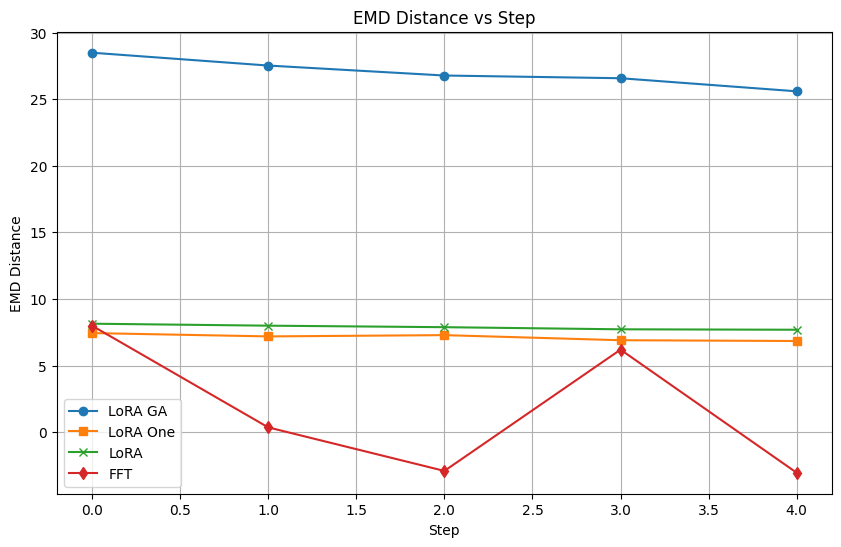

In [ ]:
import matplotlib.pyplot as plt
data = np.load(f'emd_distance_5_pretrainiter_{pretrain_iter}_variants_gamma_{gamma}.npz')
step_num = 10
step_list = data['step'][:step_num]
print(np.log(data['fft'][:step_num]))
print(np.log(data['lora_one'][:step_num]))
lora_ga_list = np.log(data['lora_ga'][:step_num])
lora_one_list = np.log(data['lora_one'][:step_num])
lora_sb_list = np.log(data['lora_sb'][:step_num])
lora_list = np.log(data['lora'][:step_num])
fft_list = np.log(data['fft'][:step_num])
# lora_ga_list = data['lora_ga'][:step_num]
# lora_one_list = data['lora_one'][:step_num]
# lora_sb_list = data['lora_sb'][:step_num]
# lora_list = data['lora'][:step_num]
# fft_list = data['fft'][:step_num]   
plt.figure(figsize=(10, 6))
# plt.axhline(y=np.log(2426), color='k', linestyle='--', label='Pre-trained')
plt.plot(step_list, np.array(lora_ga_list), marker='o', label='LoRA GA')
plt.plot(step_list, np.array(lora_one_list), marker='s', label='LoRA One')
# plt.plot(step_list, np.array(lora_sb_list), marker='^', label='LoRA SB')
plt.plot(step_list, np.array(lora_list), marker='x', label='LoRA')
plt.plot(step_list, np.array(fft_list), marker='d', label='FFT')
plt.xlabel('Step')
plt.ylabel('EMD Distance')
plt.title('EMD Distance vs Step')
plt.legend()
plt.grid(True)
plt.show()

#### Sample from trained model

In [ ]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(vf)

In [ ]:
# step size for ode solver
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = 50000  # batch size
eps_time = 1e-2
T = torch.linspace(0,1,10)  # sample times
T = T.to(device=device)

x_init = torch.randn((batch_size, 2), dtype=torch.float32, device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model

### Visualize the path

In [ ]:
sol = sol.cpu().numpy()
T = T.cpu()

fig, axs = plt.subplots(1, 10,figsize=(20,20))
print(sol[9, :, :2])
for i in range(10):
    H= axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-3,3), (-3,3)))
    
    cmin = 0.0
    cmax = torch.quantile(torch.from_numpy(H[0]), 0.99).item()
    
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-3,3), (-3,3)), norm=norm)
    
    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))
    
plt.tight_layout()
plt.show()

## Compute and Visualize Model Log-likelihood

In [ ]:
nll, exact_nll = evaluate_result(vf, data_mode=mode, visualize=True)
print(f"Load Model From: {path}, Likelihood: {nll}, Exact NLL: {exact_nll}")

In [ ]:
from torch.distributions import Independent, Normal

In [ ]:
# sample with likelihood

T = torch.tensor([1., 0.])  # sample times
T = T.to(device=device)

grid_size = 200
x_1 = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
x_1 = torch.stack([x_1[0].flatten(), x_1[1].flatten()], dim=1).to(device)
print(x_1.shape)

In [ ]:

import pickle
from peft import LoraConfig, get_peft_model, PeftModel
# step_list = [2]
step_list = [3, 50, 100, 150, 200, 250, 300, 350, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000]
lora_exact_nll_list = []
lora_one_nll_list = []
full_nll_list = []

for step in step_list:
    path_list = [
        # f"/home/u5649209/workspace/flow_matching/ckpts/lora/{step}_new",
        f"/home/u5649209/workspace/flow_matching/ckpts/{lora_init_mode}_{gradient_base}_{gradient_iter}/{step}_new",
        # f"/home/u5649209/workspace/flow_matching/ckpts/full/{step}_new.pth"
    ]
    for path in path_list:
    # path = f"/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_{step}"
        if "lora" in path:
            is_lora = True
        else:
            is_lora = False
        if is_eval:
            # load the model
            if is_lora:
                vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
                vf.load_state_dict(torch.load("/home/u5649209/workspace/flow_matching/ckpts/full/2000_new.pth", map_location=device))
                vf = PeftModel.from_pretrained(vf, path)
            else:
                vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
                vf.load_state_dict(torch.load(path, map_location=device))

        _, exact_nll = evaluate_result(vf, data_mode=mode, visualize=False)
        
        if "lora-one" in path:
            lora_one_nll_list.append(exact_nll.cpu().item())
        elif "lora" in path:
            lora_exact_nll_list.append(exact_nll.cpu().item())
        else:
            full_nll_list.append(exact_nll.cpu().item())
import matplotlib.pyplot as plt
data = np.load('nll_moons_new.npz')
step_list = data['step']
lora_exact_nll_list = np.log(data['lora_exact_nll'])
full_nll_list = np.log(data['full_nll'])

plt.figure(figsize=(10, 6))
plt.plot(step_list, np.array(lora_exact_nll_list), marker='o', label='LoRA')
plt.plot(step_list, np.log(np.array(lora_one_nll_list)), marker='s', label='LoRA one')
plt.plot(step_list, np.array(full_nll_list), marker='^', label='Full Model')
plt.xlabel('Step')
plt.ylabel('Exact NLL')
plt.title('Exact NLL vs Step')
plt.legend()
plt.grid(True)
plt.show()
